In [1]:
# ==========================================
# ACTIVE LEARNING LOOP: THE OSCILLATOR BENCHMARK
# ==========================================
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import copy
import sys
import os
import pickle
from tqdm import tqdm
from scipy.integrate import odeint

# 1. SETUP PATHS & IMPORTS
# Allow importing from the current folder and parent
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from active_learning_loop._lab import VirtualLab
from active_learning_loop._designer import ExperimentDesigner
from active_learning_loop._learner import Learner
from circuits_miner.get_system_equations_pop import system_equations_DsRed_pop

In [2]:
# ==========================================
# STEP A: LOAD TOPOLOGY (The Circuit Structure)
# ==========================================
print(">> [Step A] Loading Circuit Topology from GCAD Results...")

current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
miner_dir = os.path.join(parent_dir, 'circuits_miner')

if miner_dir not in sys.path:
    sys.path.append(miner_dir)

try:
    import define_circuit 
    print("   [System] Successfully linked 'define_circuit' module for unpickling.")
except ImportError:
    print("   [Warning] Could not import define_circuit directly. Unpickling might fail.")

MINER_RESULTS_ROOT = os.path.join(miner_dir, "results")

if not os.path.exists(MINER_RESULTS_ROOT):
    raise FileNotFoundError(f"Could not find miner results at {MINER_RESULTS_ROOT}")

all_subdirs = [
    os.path.join(MINER_RESULTS_ROOT, d) 
    for d in os.listdir(MINER_RESULTS_ROOT) 
    if os.path.isdir(os.path.join(MINER_RESULTS_ROOT, d))
]

z1z2_runs = [d for d in all_subdirs if "Z1Z2" in d]
if not z1z2_runs:
    z1z2_runs = all_subdirs 

if not z1z2_runs:
    raise FileNotFoundError("No Miner results found! Cannot load topology.")

latest_subdir = max(z1z2_runs, key=os.path.getmtime)
print(f"   Loading topology source: {latest_subdir}")

try:
    winner_pop = pd.read_pickle(f"{latest_subdir}/final_population.pkl")
    winner_df = pd.read_pickle(f"{latest_subdir}/final_objectives_df.pkl")
except Exception as e:
    print(f"   [Error] Failed to load pickle files: {e}")
    raise

winner_df['circuit_object'] = [ind[0] for ind in winner_pop]

if 'prominence_rel' in winner_df.columns:
    winner_df['abs_prom'] = winner_df['prominence_rel'].abs()
    best_row = winner_df.sort_values('abs_prom', ascending=False).iloc[0]
else:
    best_row = winner_df.iloc[0]

target_circuit = best_row['circuit_object']

print(f"   [Success] Loaded Topology: {target_circuit.edge_list}")
print(f"   [Info] Nominal Doses: {target_circuit.dose}")

>> [Step A] Loading Circuit Topology from GCAD Results...
   [System] Successfully linked 'define_circuit' module for unpickling.
   Loading topology source: c:\Users\KuangQi\Desktop\GCAD-SDL\GCAD-SDL\Experimental Design\circuits_miner\results\Miner_Z1Z2_DsRed_2026-02-11
   [Success] Loaded Topology: [('P1', 'Z1'), ('P1', 'I2'), ('Z1', 'Rep'), ('Z1', 'I2'), ('Z1', 'Z1'), ('I2', 'Z1'), ('I2', 'Rep')]
   [Info] Nominal Doses: {'Rep': 200, 'I2': 45, 'Z1': 75}


In [3]:
# ==========================================
# STEP B: LOAD PARAMETERS (The Prior Belief)
# ==========================================
print("\n>> [Step B] Loading Parameter Ensemble & Physics...")

DATA_PATH = "active_learning_data.pkl" 

if os.path.exists(DATA_PATH):
    with open(DATA_PATH, "rb") as f:
        data = pickle.load(f)
    print(f"   [Success] Loaded {len(data['parameters'])} parameter sets.")
else:
    raise FileNotFoundError(f"Could not find {DATA_PATH}.")

promo_path = os.path.join(miner_dir, "promo.pkl")

if os.path.exists(promo_path):
    with open(promo_path, "rb") as f:
        nominal_promo = pickle.load(f)
    print("   [Success] Loaded nominal promoter parameters (promo.pkl).")
else:
    raise FileNotFoundError("Could not find promo.pkl.")


>> [Step B] Loading Parameter Ensemble & Physics...
   [Success] Loaded 200 parameter sets.
   [Success] Loaded nominal promoter parameters (promo.pkl).


In [4]:
# ==========================================
# STEP C: CONFIGURATION
# ==========================================
MAX_CYCLES = 7              # Max loops allowed before forced stop
SECRET_INDEX = 84           # The "Hidden Truth" (True Pulse)
SELECTION_RATIO = 0.2       # Keep top 20%
PERTURBATION = 0.1          # Mutate by 10%
NOISE_LEVEL = 0.02          # 2% Lab Noise

# The ultimate stopping criterion:
CONVERGENCE_UNCERTAINTY = 1e-5  


>> [Step D] Initializing Virtual Lab with Secret Mutant #84...

 RUNNING BENCHMARK: HYBRID METRIC


Lab Experiment Cycle 1...:   0%|          | 0/7 [08:48<?, ?it/s]


   [Designer] Cycle 1 Max Uncertainty: 1.5408e+04
   [Designer] Requesting Lab Experiment at 1.80x


Updating Beliefs Cycle 1...:   0%|          | 0/7 [08:48<?, ?it/s]

   [Learner] Assessing 200 parameter sets...


Updating Beliefs Cycle 1...:   0%|          | 0/7 [09:15<?, ?it/s]

   [Learner] Selected top 40 candidates. Min Error (NMSE): 4.4112e-04
   [Learner] Best Model NMSE: 4.4112e-04


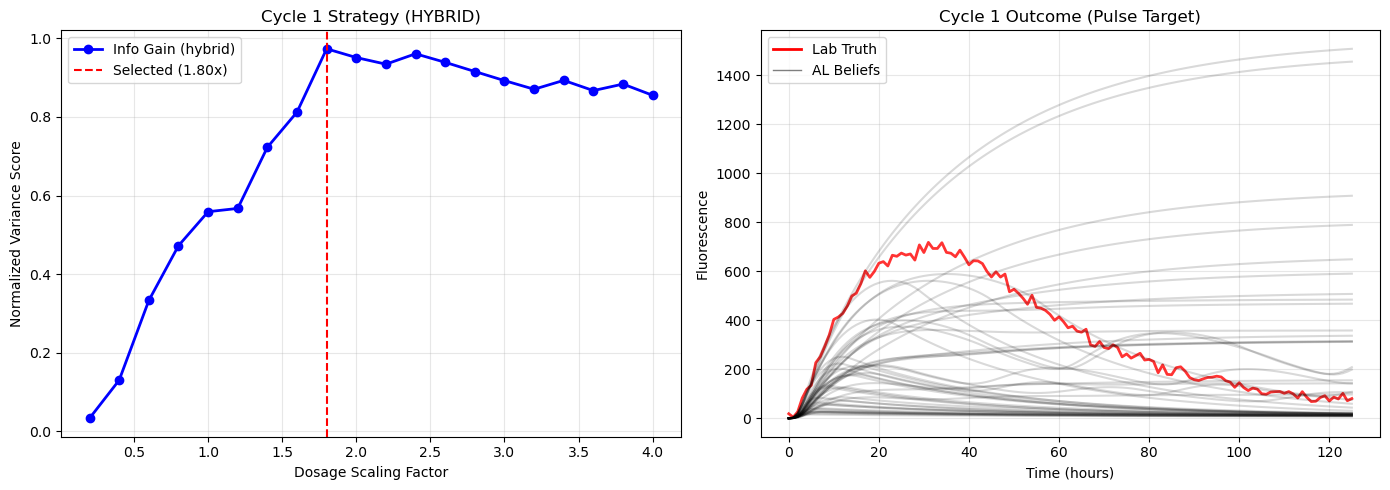

Updating Beliefs Cycle 2...:  14%|█▍        | 1/7 [19:28<56:03, 560.59s/it]


   [Designer] Cycle 2 Max Uncertainty: 4.2712e+04
   [Designer] Requesting Lab Experiment at 1.60x
   [Learner] Assessing 200 parameter sets...


Updating Beliefs Cycle 2...:  14%|█▍        | 1/7 [19:46<56:03, 560.59s/it]

   [Learner] Selected top 40 candidates. Min Error (NMSE): 3.0284e-04
   [Learner] Best Model NMSE: 3.0284e-04


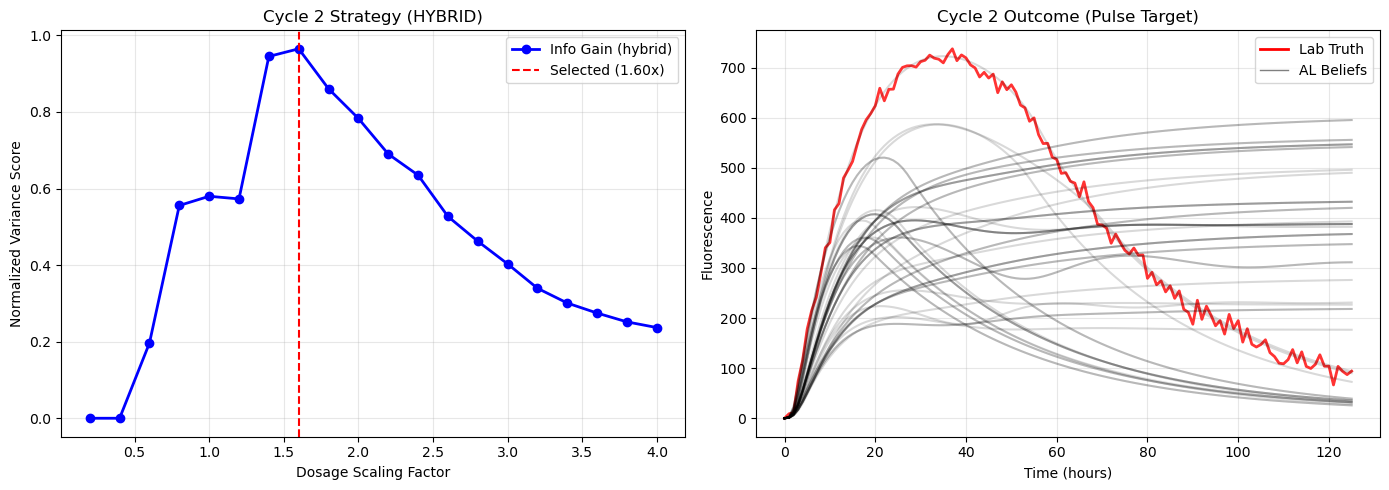

Updating Beliefs Cycle 3...:  29%|██▊       | 2/7 [30:14<50:09, 601.80s/it]


   [Designer] Cycle 3 Max Uncertainty: 6.9643e+04
   [Designer] Requesting Lab Experiment at 1.40x
   [Learner] Assessing 200 parameter sets...


Updating Beliefs Cycle 3...:  29%|██▊       | 2/7 [30:46<50:09, 601.80s/it]

   [Learner] Selected top 40 candidates. Min Error (NMSE): 4.1771e-04
   [Learner] Best Model NMSE: 4.1771e-04


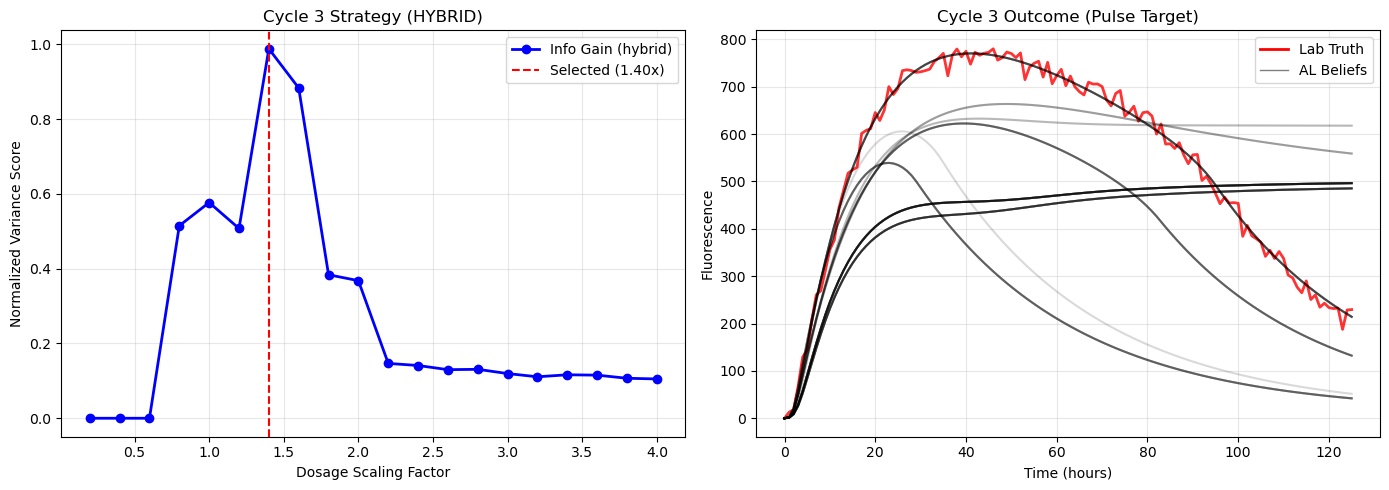

Lab Experiment Cycle 4...:  43%|████▎     | 3/7 [40:43<42:04, 631.00s/it]  


   [Designer] Cycle 4 Max Uncertainty: 9.7754e+02
   [Designer] Requesting Lab Experiment at 1.60x


Updating Beliefs Cycle 4...:  43%|████▎     | 3/7 [40:43<42:04, 631.00s/it]

   [Learner] Assessing 200 parameter sets...


Updating Beliefs Cycle 4...:  43%|████▎     | 3/7 [41:26<42:04, 631.00s/it]

   [Learner] Selected top 40 candidates. Min Error (NMSE): 3.5001e-04
   [Learner] Best Model NMSE: 3.5001e-04


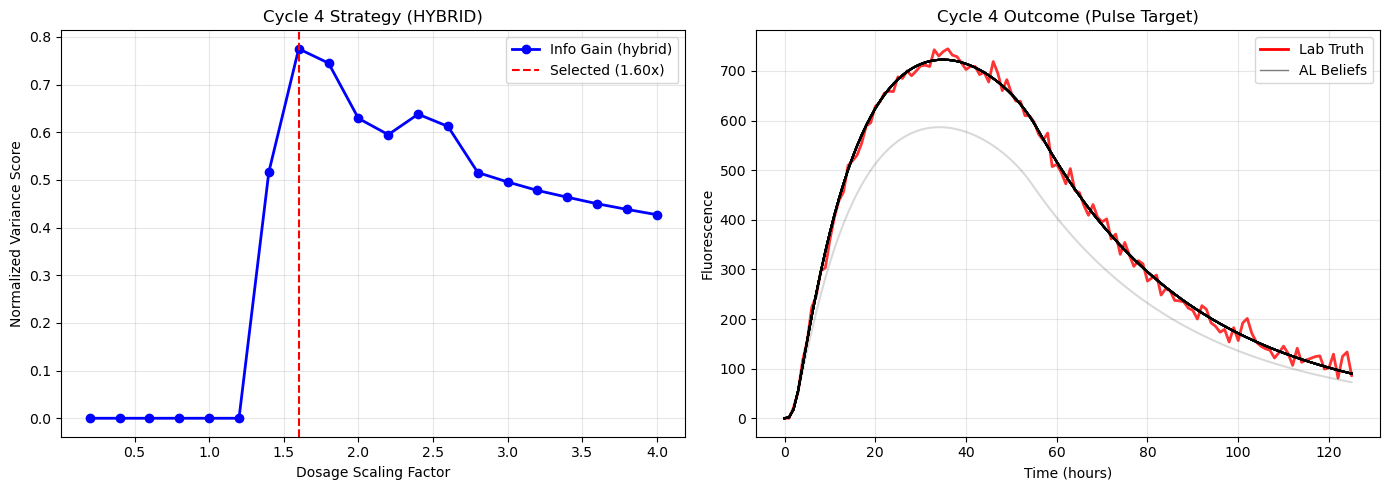

Designing Cycle 5...:  57%|█████▋    | 4/7 [53:06<39:50, 796.67s/it]       



   [Designer] Cycle 5 Max Uncertainty: 5.1699e-26
 CONVERGED: Uncertainty < 1e-05.

 RUNNING BENCHMARK: TIME_SPECIFIC METRIC


Updating Beliefs Cycle 1...:   0%|          | 0/7 [11:35<?, ?it/s]


   [Designer] Cycle 1 Max Uncertainty: 1.0158e+05
   [Designer] Requesting Lab Experiment at 0.40x
   [Learner] Assessing 200 parameter sets...


Updating Beliefs Cycle 1...:   0%|          | 0/7 [12:11<?, ?it/s]

   [Learner] Selected top 40 candidates. Min Error (NMSE): 3.3194e-04
   [Learner] Best Model NMSE: 3.3194e-04


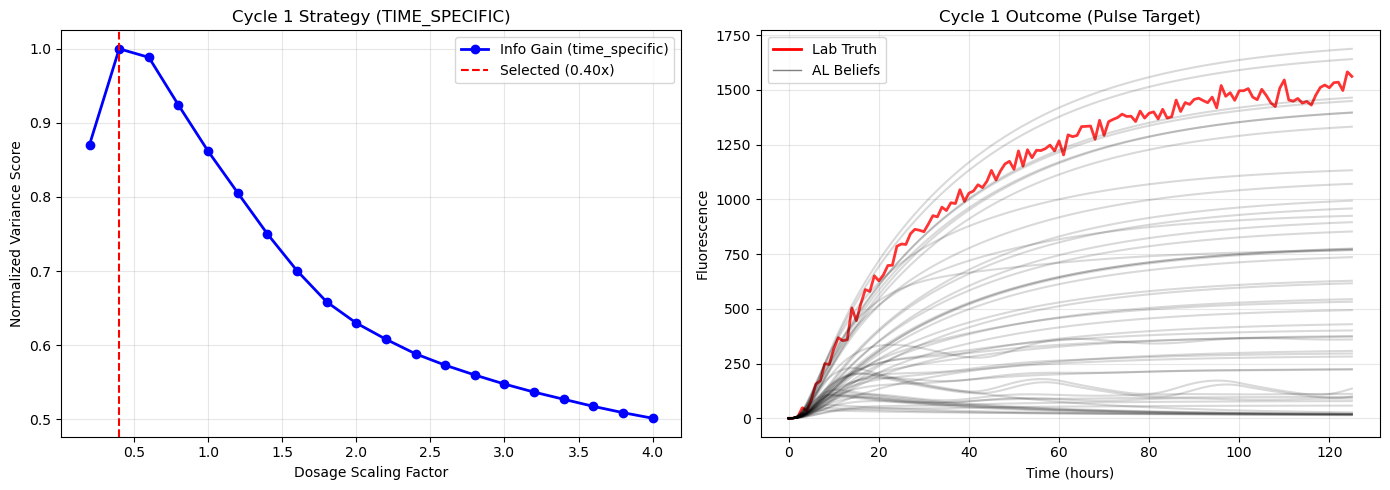

Lab Experiment Cycle 2...:  14%|█▍        | 1/7 [23:53<1:14:07, 741.24s/it]  


   [Designer] Cycle 2 Max Uncertainty: 1.4569e+05
   [Designer] Requesting Lab Experiment at 3.20x


Updating Beliefs Cycle 2...:  14%|█▍        | 1/7 [23:53<1:14:07, 741.24s/it]

   [Learner] Assessing 200 parameter sets...


Updating Beliefs Cycle 2...:  14%|█▍        | 1/7 [24:33<1:14:07, 741.24s/it]

   [Learner] Selected top 40 candidates. Min Error (NMSE): 4.4007e-04
   [Learner] Best Model NMSE: 4.4007e-04


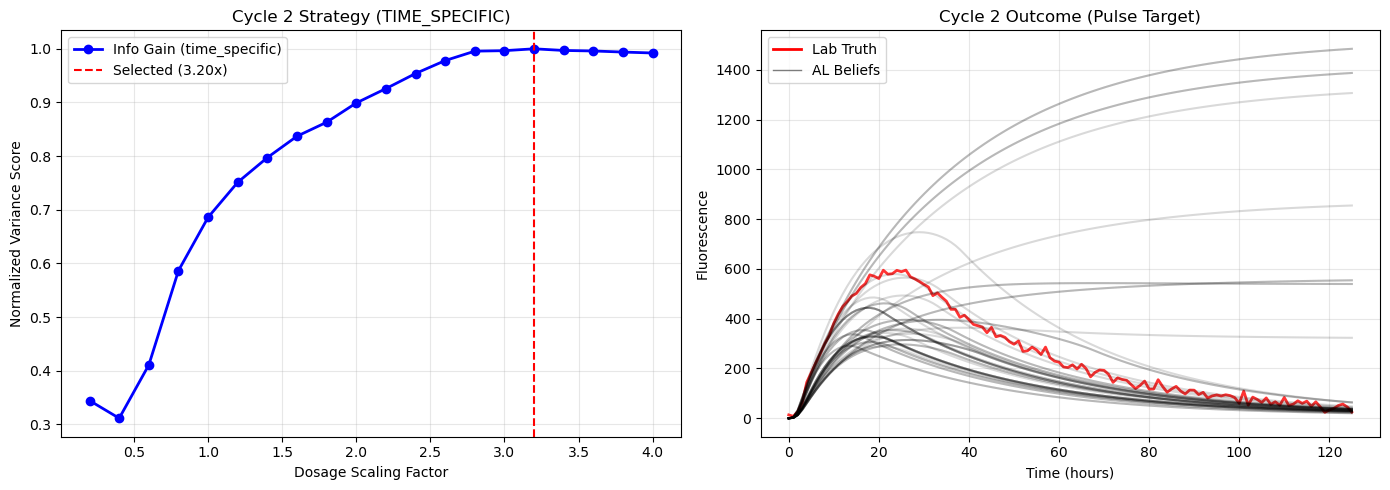

Updating Beliefs Cycle 3...:  29%|██▊       | 2/7 [38:14<1:01:51, 742.39s/it]


   [Designer] Cycle 3 Max Uncertainty: 6.9100e+04
   [Designer] Requesting Lab Experiment at 1.00x
   [Learner] Assessing 200 parameter sets...


Updating Beliefs Cycle 3...:  29%|██▊       | 2/7 [38:48<1:01:51, 742.39s/it]

   [Learner] Selected top 40 candidates. Min Error (NMSE): 3.5613e-04
   [Learner] Best Model NMSE: 3.5613e-04


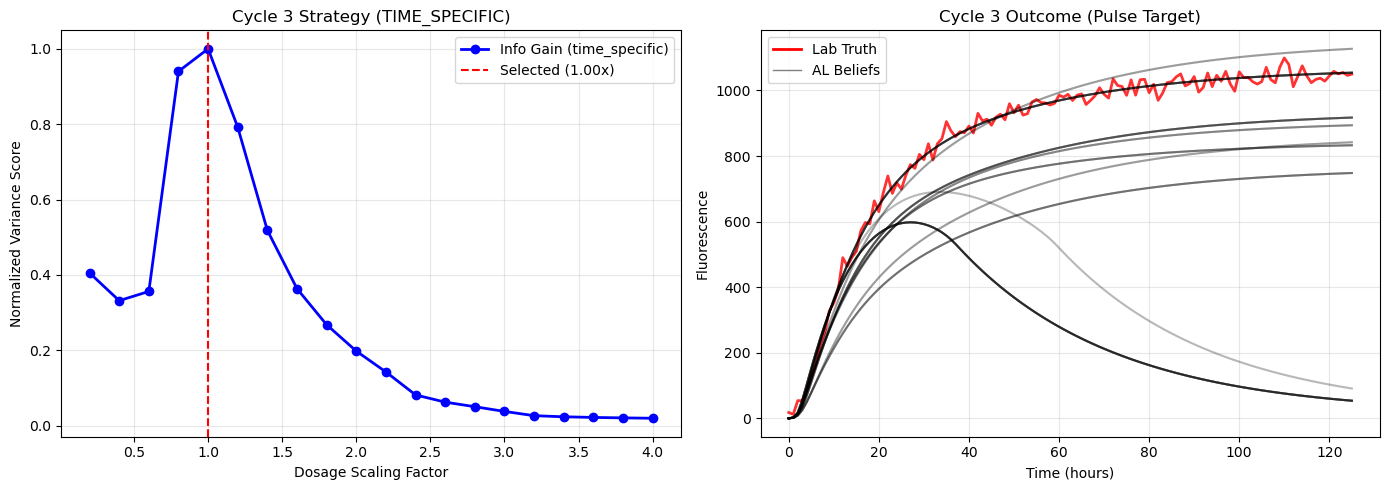

Designing Cycle 4...:  43%|████▎     | 3/7 [52:40<1:10:14, 1053.56s/it]      


   [Designer] Cycle 4 Max Uncertainty: 1.0760e-23
 CONVERGED: Uncertainty < 1e-05.

>> BENCHMARKS COMPLETE.


In [5]:
# ==========================================
# STEP D & E: THE ALGORITHM BENCHMARK
# ==========================================
print(f"\n>> [Step D] Initializing Virtual Lab with Secret Mutant #{SECRET_INDEX}...")

# 1. Extract Secret Parameters (Truth)
true_params = data["parameters"][SECRET_INDEX]
if "promo_params" in data and data["promo_params"][SECRET_INDEX] is not None:
    true_promo_params = data["promo_params"][SECRET_INDEX]
else:
    true_promo_params = nominal_promo

# 2. Initialize the Single Virtual Lab
lab = VirtualLab(
    topology=target_circuit, 
    true_params=true_params, 
    true_promo_params=true_promo_params, 
    noise_level=NOISE_LEVEL
)

metrics_to_test = ["hybrid", "time_specific"]
benchmark_results = {}

for metric in metrics_to_test:
    print(f"\n{'='*50}\n RUNNING BENCHMARK: {metric.upper()} METRIC\n{'='*50}")
    
    # Reset the "Belief Cloud" to the exact same starting point for a fair fight
    current_ensemble = copy.deepcopy(data["parameters"])
    if "promo_params" in data and data["promo_params"] is not None:
        current_promos = copy.deepcopy(data["promo_params"])
    else:
        current_promos = [nominal_promo] * len(current_ensemble)

    # Initialize Modules
    learner = Learner(target_circuit, selection_ratio=SELECTION_RATIO, perturbation_scale=PERTURBATION)
    designer = ExperimentDesigner(target_circuit, variance_metric=metric)
    
    history = []
    pbar = tqdm(range(MAX_CYCLES), desc=f"AL Loop ({metric.upper()})")
    
    for cycle in pbar:
        # --- PHASE 1: DESIGN (AND CONVERGENCE CHECK) ---
        pbar.set_description(f"Designing Cycle {cycle+1}...")
        
        best_dose, scores, dosages, max_uncertainty = designer.design_experiment(current_ensemble, current_promos)
        pbar.write(f"\n   [Designer] Cycle {cycle+1} Max Uncertainty: {max_uncertainty:.4e}")
        
        # Check if the cloud has collapsed!
        if max_uncertainty < CONVERGENCE_UNCERTAINTY:
            pbar.write(f" CONVERGED: Uncertainty < {CONVERGENCE_UNCERTAINTY}.")
            break
            
        pbar.write(f"   [Designer] Requesting Lab Experiment at {best_dose:.2f}x")
            
        # --- PHASE 2: EXPERIMENT ---
        pbar.set_description(f"Lab Experiment Cycle {cycle+1}...")
        t_exp, y_exp = lab.run_experiment(best_dose)
        
        # --- PHASE 3: UPDATE ---
        pbar.set_description(f"Updating Beliefs Cycle {cycle+1}...")
        new_ensemble, new_promos, best_error = learner.update_belief(
            current_ensemble, current_promos, best_dose, t_exp, y_exp
        )
        pbar.write(f"   [Learner] Best Model NMSE: {best_error:.4e}")
        
        # --- PHASE 4: SAVE CHECKPOINT ---
        cycle_snapshot = {
            'cycle': cycle,
            'best_dose': best_dose,
            'max_uncertainty': max_uncertainty,
            'best_error': best_error,
            'updated_ensemble': copy.deepcopy(new_ensemble),  
            'updated_promos': copy.deepcopy(new_promos)
        }
        history.append(cycle_snapshot)
        
        filename = f"al_history_pulse_{metric}_cycle_{cycle+1}.pkl"
        with open(filename, "wb") as f:
            pickle.dump(cycle_snapshot, f)
            
        # --- PHASE 5: VISUALIZATION ---
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        # Plot 1: The OED Landscape
        axes[0].plot(dosages, scores, 'b-o', linewidth=2, label=f'Info Gain ({metric})')
        axes[0].axvline(best_dose, color='r', linestyle='--', label=f'Selected ({best_dose:.2f}x)')
        axes[0].set_title(f"Cycle {cycle+1} Strategy ({metric.upper()})")
        axes[0].set_xlabel("Dosage Scaling Factor")
        axes[0].set_ylabel("Normalized Variance Score")
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # Plot 2: Lab Truth vs Belief Cloud
        axes[1].plot(t_exp, y_exp, 'r-', linewidth=2, label='Lab Data (Truth)', alpha=0.8)
        
        sim_dose = {k: v * best_dose for k, v in target_circuit.dose.items() if k != 'Rep'}
        if 'Rep' in target_circuit.dose: sim_dose['Rep'] = target_circuit.dose['Rep']
        plot_topo = type(target_circuit)(target_circuit.edge_list, sim_dose, target_circuit.promo_node)
        
        subset_size = min(50, len(current_ensemble))
        indices = np.random.choice(len(current_ensemble), subset_size, replace=False)
        for i in indices:
            y_pred = odeint(
                system_equations_DsRed_pop, np.zeros(plot_topo.num_states * 2), t_exp,
                args=('on', np.ones(5), plot_topo, current_promos[i], current_ensemble[i])
            )[:, -1]
            axes[1].plot(t_exp, y_pred, 'k-', alpha=0.15)

        axes[1].set_title(f"Cycle {cycle+1} Outcome (Pulse Target)")
        axes[1].set_xlabel("Time (hours)")
        axes[1].set_ylabel("Fluorescence")
        
        from matplotlib.lines import Line2D
        custom_lines = [Line2D([0], [0], color='r', lw=2), Line2D([0], [0], color='k', lw=1, alpha=0.5)]
        axes[1].legend(custom_lines, ['Lab Truth', 'AL Beliefs'])
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Prepare state for the next cycle
        current_ensemble = new_ensemble
        current_promos = new_promos
        
    # Store history for potential comparative analysis later
    benchmark_results[metric] = history

print("\n>> BENCHMARKS COMPLETE.")